# the packages

In [1]:
# hddm
import hddm
import kabuki
import pymc

# design matrix
from patsy import dmatrix

# data analysis
import pandas as pd
import numpy as np

# beyasian modeling
import bambi as bmb

# plot
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import ptitprince as pt

# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

# rmANOVA
from statsmodels.stats.anova import AnovaRM

# search file
import glob

# system
import os,sys,time

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
# set the figure theme
sns.set_theme(style="whitegrid")

# simulation1(v ~ coherence,t ~ attention)

In [3]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 30
trials_per_level = 100

# set the group parameter
# intercept and slope of v
v_int = 1
v_coh = 0.5
v_sig1 = 0.05
v_sig2 = 0.05
# intercept and slope of t
t_int = 0.3
t_pri = 0.2
t_sig1 = 0.02
t_sig2 = 0.02
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of z
z_int = 0.5
z_sig = 0.1


## the hierarchical struction

In [4]:
# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig1,[n_subjects,2])
t_pri_subj = np.random.normal(t_pri,t_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
params = pd.DataFrame()
for i in range(n_subjects):
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    t_yes = t_int_subj[i] - t_pri_subj[i]
    t_no = t_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter z
    z = z_int_subj[i]
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t_yes[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t_no[0], 'z':z[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t_yes[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t_no[1], 'z':z[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # add column stimulus
    data_a['stimulus'] = 1   # face
    data_b['stimulus'] = 0

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = i

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    # combine data
    df = df.append(data)
    

    # create dataframe
    params_a = pd.DataFrame(params_a).T.reset_index().rename(columns={'index': 'condition'})
    params_b = pd.DataFrame(params_b).T.reset_index().rename(columns={'index': 'condition'})
    
    # add stmilulus
    params_a['stimulus'] = 1
    params_b['stimulus'] = 0

    # combine two stimulus
    param = params_a.append(params_b,ignore_index=True)
    
    # add column coherence
    param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
    param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0
    
    # add column spatial priotiziation
    param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
    param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0
    
    # add subject
    param['subj_idx'] = i

    # combine params
    params = params.append(param)

## the non-hierarchical struction

In [6]:
# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':v_int, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':v_int, 'a':a_int, 't':t_int-t_pri, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# data
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

# params
# create dataframe
levels = ['level1','level2','level3','level4']

paramsa = pd.DataFrame()
paramsb = pd.DataFrame()

# combine the params for each level
for level in levels:
    parama = pd.DataFrame(params_a[level]).reset_index().rename(columns={'index': 'subj_idx'})
    parama['condition'] = level
    paramsa = paramsa.append(parama,ignore_index=True)
    
    paramb = pd.DataFrame(params_b[level]).reset_index().rename(columns={'index': 'subj_idx'})
    paramb['condition'] = level
    paramsb = paramsb.append(paramb,ignore_index=True)

# add stmilulus
paramsa['stimulus'] = 1
paramsb['stimulus'] = 0
# combine two stimulus
param = paramsa.append(paramsb,ignore_index=True)

# add column coherence
param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0

## the visualization 

In [7]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.559181,1.0,0,level1,1,1.0,1.0
1,0.321181,1.0,0,level1,1,1.0,1.0
2,0.293181,1.0,0,level1,1,1.0,1.0
3,0.455181,1.0,0,level1,1,1.0,1.0
4,0.580181,1.0,0,level1,1,1.0,1.0
...,...,...,...,...,...,...,...
795,0.664851,0.0,29,level4,0,0.0,0.0
796,0.605851,1.0,29,level4,0,0.0,0.0
797,0.443851,1.0,29,level4,0,0.0,0.0
798,0.481851,1.0,29,level4,0,0.0,0.0


In [8]:
data

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.234013,0.0,0,level1,1.0,1.0,1.0
1,0.234509,0.0,0,level1,1.0,1.0,1.0
2,0.404129,1.0,0,level1,1.0,1.0,1.0
3,0.551129,1.0,0,level1,1.0,1.0,1.0
4,0.625750,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
23995,0.502132,1.0,29,level4,0.0,0.0,0.0
23996,0.448713,1.0,29,level4,0.0,0.0,0.0
23997,1.304022,1.0,29,level4,0.0,0.0,0.0
23998,0.461194,1.0,29,level4,0.0,0.0,0.0


In [9]:
params

,condition,v,a,t,z,sv,sz,st,stimulus,coherence,attention,subj_idx
0,level1,1.561993,1.367778,0.170181,0.457978,0.0,0.0,0.0,1,1.0,1.0,0
1,level2,1.561993,1.367778,0.316372,0.457978,0.0,0.0,0.0,1,1.0,0.0,0
2,level3,1.013021,1.367778,0.170181,0.457978,0.0,0.0,0.0,1,0.0,1.0,0
3,level4,1.013021,1.367778,0.316372,0.457978,0.0,0.0,0.0,1,0.0,0.0,0
4,level1,1.355954,1.345162,0.144846,0.571113,0.0,0.0,0.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,level4,0.977915,1.184883,0.288438,0.337422,0.0,0.0,0.0,1,0.0,0.0,29
4,level1,1.418044,1.441141,0.079041,0.397107,0.0,0.0,0.0,0,1.0,1.0,29
5,level2,1.418044,1.441141,0.286851,0.397107,0.0,0.0,0.0,0,1.0,0.0,29
6,level3,0.975464,1.441141,0.079041,0.397107,0.0,0.0,0.0,0,0.0,1.0,29


In [10]:
param

,subj_idx,v,a,t,z,sv,sz,st,condition,stimulus,coherence,attention
0,0,1.391437,1.499735,0.128298,0.349371,0.165144,0.126594,0.149139,level1,1,1.0,1.0
1,1,1.459784,1.478244,0.084364,0.537152,0.004700,0.074713,0.057779,level1,1,1.0,1.0
2,2,1.517293,1.240556,0.082071,0.515961,0.114568,0.032680,0.043289,level1,1,1.0,1.0
3,3,1.529776,1.449573,0.140863,0.398836,0.084433,0.101162,0.212582,level1,1,1.0,1.0
4,4,1.493768,1.494922,0.074892,0.588477,0.083453,0.079930,0.100354,level1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,25,0.980489,1.480073,0.336111,0.549541,0.007183,0.156149,0.003886,level4,0,0.0,0.0
236,26,0.931164,1.560618,0.400477,0.551703,0.016966,0.059456,0.097765,level4,0,0.0,0.0
237,27,0.984148,1.313544,0.314008,0.510376,0.014199,0.007513,0.092615,level4,0,0.0,0.0
238,28,0.962336,1.393139,0.520631,0.519838,0.086327,0.113698,0.158847,level4,0,0.0,0.0


### the description subj level

In [11]:
df.rt.describe()

count    24000.000000
mean         0.584034
std          0.337363
min          0.079110
25%          0.360791
50%          0.500417
75%          0.722491
max          2.480469
Name: rt, dtype: float64

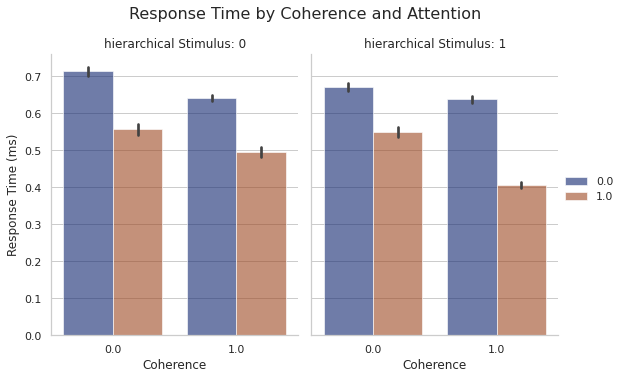

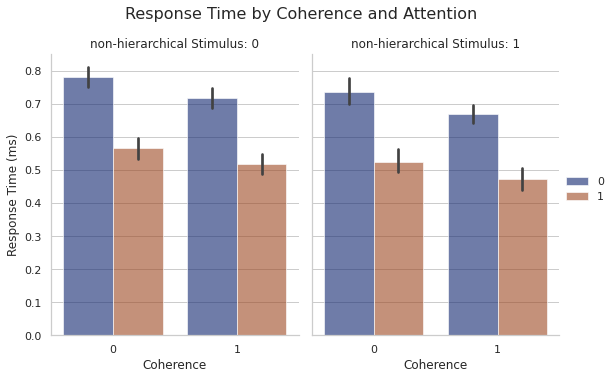

In [12]:
# hierarchical
# get the mean of accurate RTs
df_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
df_rt_sum['stimulus'] = df_rt_sum['stimulus'].astype('int64')
df_rt_sum['coherence'] = df_rt_sum['coherence'].astype('int64')
df_rt_sum['attention'] = df_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = df,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

# non-hierarchical
# get the mean of accurate RTs
data_rt_sum = data[data['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("non-hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

Text(0.5, 1, 'Response Time by Coherence and Attention')

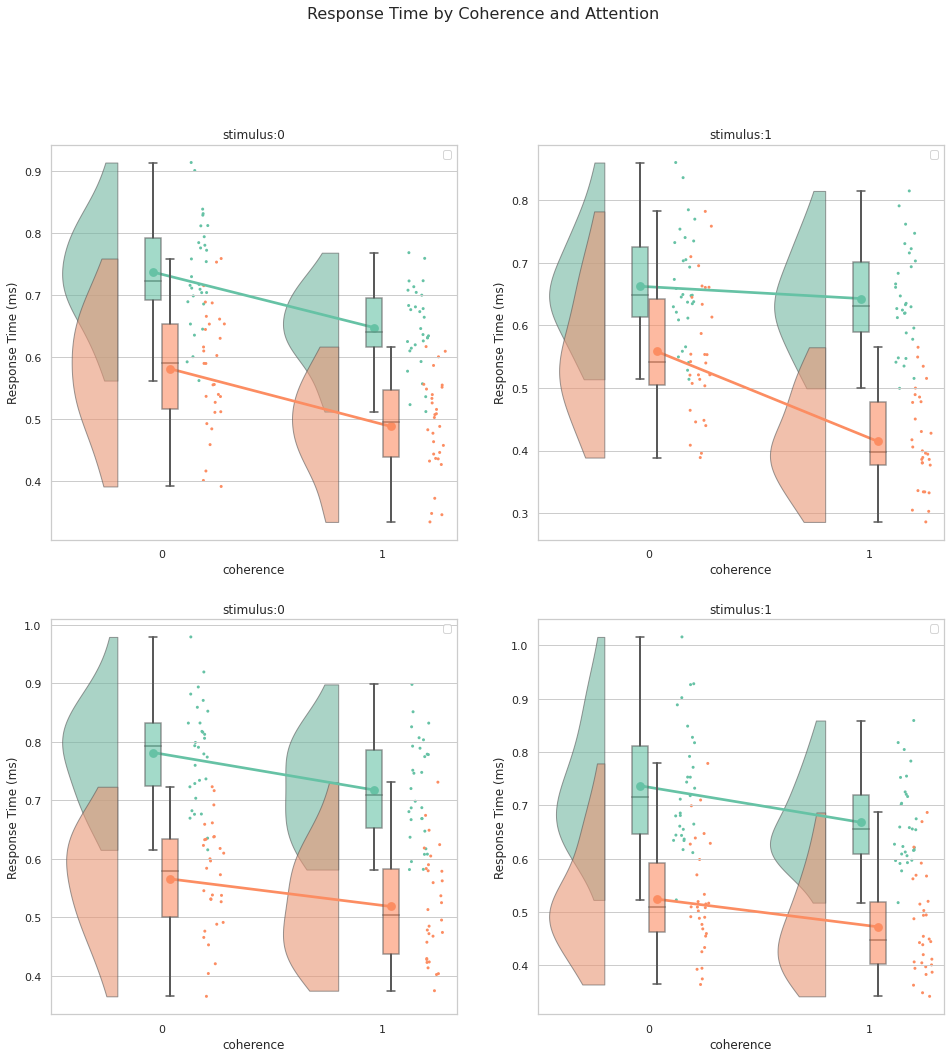

In [13]:
f, ax = plt.subplots(2,2,figsize=(16, 16))
# non-hierarchical
# the right figure
ax[0,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,0].legend('')
ax[0,0].set_title('stimulus:0')
ax[0,0].set_ylabel('Response Time (ms)')
# the right figure
ax[0,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,1].legend('')
ax[0,1].set_title('stimulus:1')
ax[0,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)
# non-hierarchical
ax[1,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,0].legend('')
ax[1,0].set_title('stimulus:0')
ax[1,0].set_ylabel('Response Time (ms)')
# the right figure
ax[1,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,1].legend('')
ax[1,1].set_title('stimulus:1')
ax[1,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

In [14]:
# ANOVA for hierarchical
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                    1262.4996 1.0000 29.0000 0.0000
attention                    3642.3001 1.0000 29.0000 0.0000
stimulus                        3.6866 1.0000 29.0000 0.0647
coherence:attention          1305.1682 1.0000 29.0000 0.0000
coherence:stimulus             17.1839 1.0000 29.0000 0.0003
attention:stimulus             32.9558 1.0000 29.0000 0.0000
coherence:attention:stimulus 1794.3197 1.0000 29.0000 0.0000

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    226.6499 1.0000 29.0000 0.0000
attention                     18.4321 1.0000 29.0000 0.0002
stimulus                       0.3712 1.0000 29.0000 0.5471
coherence:attention          137.0213 1.0000 29.0000 0.0000
coherence:stimulus      

In [15]:
# ANOVA for non-hierarchical
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                     145.9865 1.0000 29.0000 0.0000
attention                    2387.0655 1.0000 29.0000 0.0000
stimulus                        6.8383 1.0000 29.0000 0.0140
coherence:attention             3.2142 1.0000 29.0000 0.0834
coherence:stimulus              1.2722 1.0000 29.0000 0.2686
attention:stimulus              1.4408 1.0000 29.0000 0.2397
coherence:attention:stimulus    0.1417 1.0000 29.0000 0.7093

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    175.8166 1.0000 29.0000 0.0000
attention                      1.0777 1.0000 29.0000 0.3078
stimulus                       0.4723 1.0000 29.0000 0.4974
coherence:attention            0.0494 1.0000 29.0000 0.8256
coherence:stimulus      

### rt distribution

In [16]:
# flip the rt of response 0 to negative
df.loc[df['response']==0,'rt'] = -df.loc[df['response']==0,'rt']

In [17]:
# flip the rt of response 0 to negative
data.loc[data['response']==0,'rt'] = -data.loc[data['response']==0,'rt']

Text(0, 0.5, 'counts')

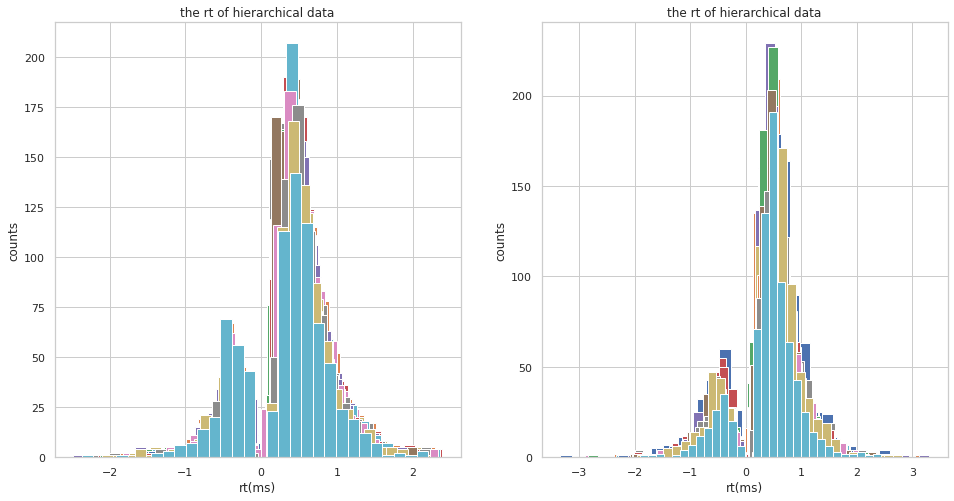

In [18]:
# create the figure 
f, ax = plt.subplots(1,2,figsize=(16, 8))

# the rt of hierarchical data
df.groupby(['subj_idx']).rt.hist(bins=30,ax=ax[0])
# the labels of hierarchical data
ax[0].set_title('the rt of hierarchical data')
ax[0].set_xlabel('rt(ms)')
ax[0].set_ylabel('counts')

# the rt of non-hierarchical data
data.groupby(['subj_idx']).rt.hist(bins=30,ax=ax[1])
# the labels of hierarchical data
ax[1].set_title('the rt of hierarchical data')
ax[1].set_xlabel('rt(ms)')
ax[1].set_ylabel('counts')

### rt distribution of different conditions

Text(0, 0.5, 'counts')

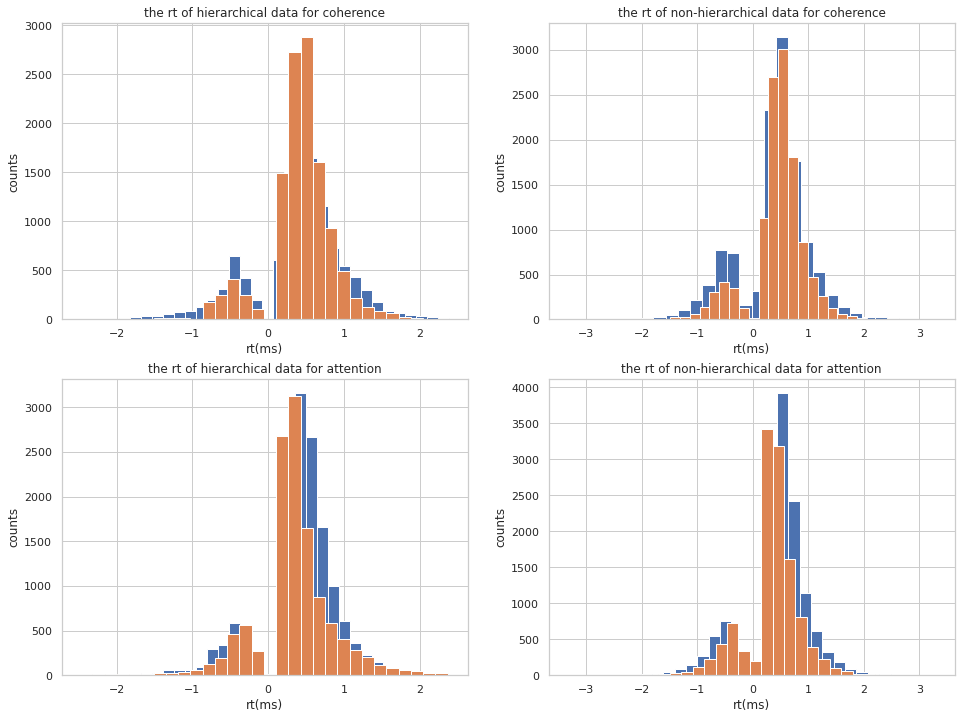

In [19]:
# create the figure 
f, ax = plt.subplots(2,2,figsize=(16, 12))

# the rt of hierarchical data for coherence
df.groupby(['coherence']).rt.hist(bins=30,ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('the rt of hierarchical data for coherence')
ax[0,0].set_xlabel('rt(ms)')
ax[0,0].set_ylabel('counts')

# the rt of non-hierarchical data for coherence
data.groupby(['coherence']).rt.hist(bins=30,ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('the rt of non-hierarchical data for coherence')
ax[0,1].set_xlabel('rt(ms)')
ax[0,1].set_ylabel('counts')

# the rt of hierarchical data for attention
df.groupby(['attention']).rt.hist(bins=30,ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('the rt of hierarchical data for attention')
ax[1,0].set_xlabel('rt(ms)')
ax[1,0].set_ylabel('counts')

# the rt of non-hierarchical data for attention
data.groupby(['attention']).rt.hist(bins=30,ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('the rt of non-hierarchical data for attention')
ax[1,1].set_xlabel('rt(ms)')
ax[1,1].set_ylabel('counts')

### the parameter distributions

Text(0, 0.5, 'density')

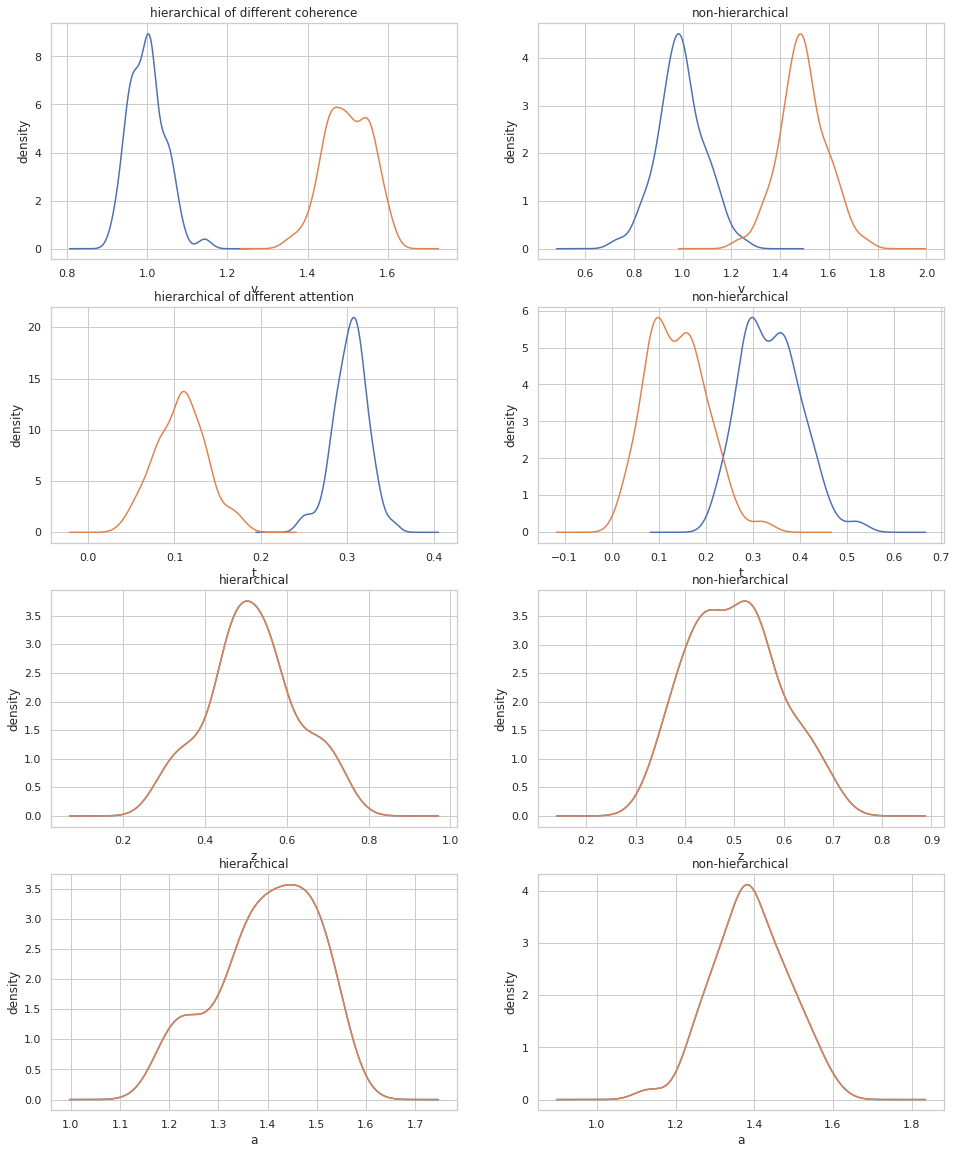

In [20]:
# create the figure 
f, ax = plt.subplots(4,2,figsize=(16, 20))

# the rt of hierarchical data for coherence
# v
params.groupby(['coherence']).v.plot.kde(ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('hierarchical of different coherence')
ax[0,0].set_xlabel('v')
ax[0,0].set_ylabel('density')

# t
params.groupby(['attention']).t.plot.kde(ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('hierarchical of different attention')
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('density')

# z
params.groupby(['attention']).z.plot.kde(ax=ax[2,0])
# the labels of hierarchical data
ax[2,0].set_title('hierarchical')
ax[2,0].set_xlabel('z')
ax[2,0].set_ylabel('density')

# a
params.groupby(['attention']).a.plot.kde(ax=ax[3,0])
# the labels of hierarchical data
ax[3,0].set_title('hierarchical')
ax[3,0].set_xlabel('a')
ax[3,0].set_ylabel('density')

# the rt of non-hierarchical data for coherence
# v
param.groupby(['coherence']).v.plot.kde(ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('non-hierarchical')
ax[0,1].set_xlabel('v')
ax[0,1].set_ylabel('density')

# t
param.groupby(['attention']).t.plot.kde(ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('non-hierarchical')
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('density')

# z
param.groupby(['attention']).z.plot.kde(ax=ax[2,1])
# the labels of hierarchical data
ax[2,1].set_title('non-hierarchical')
ax[2,1].set_xlabel('z')
ax[2,1].set_ylabel('density')

# a
param.groupby(['attention']).a.plot.kde(ax=ax[3,1])
# the labels of hierarchical data
ax[3,1].set_title('non-hierarchical')
ax[3,1].set_xlabel('a')
ax[3,1].set_ylabel('density')

## linear regression

In [21]:
params

,condition,v,a,t,z,sv,sz,st,stimulus,coherence,attention,subj_idx
0,level1,1.561993,1.367778,0.170181,0.457978,0.0,0.0,0.0,1,1.0,1.0,0
1,level2,1.561993,1.367778,0.316372,0.457978,0.0,0.0,0.0,1,1.0,0.0,0
2,level3,1.013021,1.367778,0.170181,0.457978,0.0,0.0,0.0,1,0.0,1.0,0
3,level4,1.013021,1.367778,0.316372,0.457978,0.0,0.0,0.0,1,0.0,0.0,0
4,level1,1.355954,1.345162,0.144846,0.571113,0.0,0.0,0.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,level4,0.977915,1.184883,0.288438,0.337422,0.0,0.0,0.0,1,0.0,0.0,29
4,level1,1.418044,1.441141,0.079041,0.397107,0.0,0.0,0.0,0,1.0,1.0,29
5,level2,1.418044,1.441141,0.286851,0.397107,0.0,0.0,0.0,0,1.0,0.0,29
6,level3,0.975464,1.441141,0.079041,0.397107,0.0,0.0,0.0,0,0.0,1.0,29


### model for v:

$v_{j}=\beta_{0,j} + \beta_{1,j}*C(coherence)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [22]:
# contrust model
m1 = bmb.Model("v ~ 1 + coherence + (1 + coherence|subj_idx)", data=params)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, coherence|subj_idx_offset, coherence|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, coherence, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 16 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [23]:
m1

Formula: v ~ 1 + coherence + (1 + coherence|subj_idx)
Family name: Gaussian
Link: identity
Observations: 240
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.25, sigma: 0.9018)
    coherence ~ Normal(mu: 0.0, sigma: 1.2753)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.9018))
    coherence|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.2753))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.2551)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'coherence'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>],
      dtype=object)

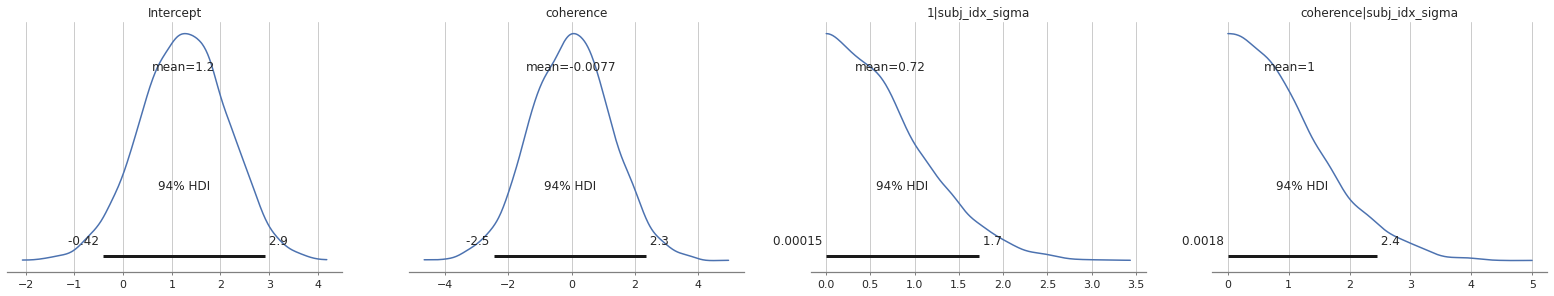

In [24]:
m1.plot_priors(var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'coherence'}>,
        <AxesSubplot:title={'center':'coherence'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>]],
      dtype=object)

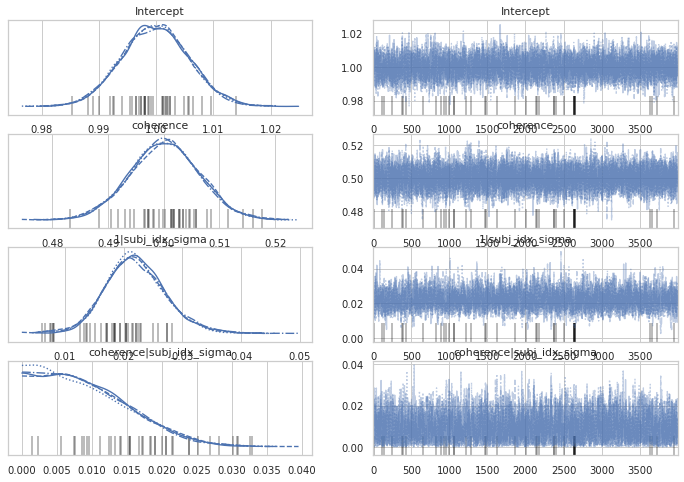

In [25]:
# Plot posteriors
az.plot_trace(
    res1,
    var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'],
    compact=True,
)

In [26]:
az.summary(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma','v_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.000,0.006,0.988,1.010,0.0,0.0,5734.0,7609.0,1.0
coherence,0.500,0.006,0.488,0.511,0.0,0.0,9954.0,7608.0,1.0
1|subj_idx_sigma,0.022,0.005,0.013,0.032,0.0,0.0,2940.0,3116.0,1.0
coherence|subj_idx_sigma,0.009,0.006,0.000,0.021,0.0,0.0,2698.0,4851.0,1.0
v_sigma,0.046,0.002,0.042,0.050,0.0,0.0,7687.0,7833.0,1.0


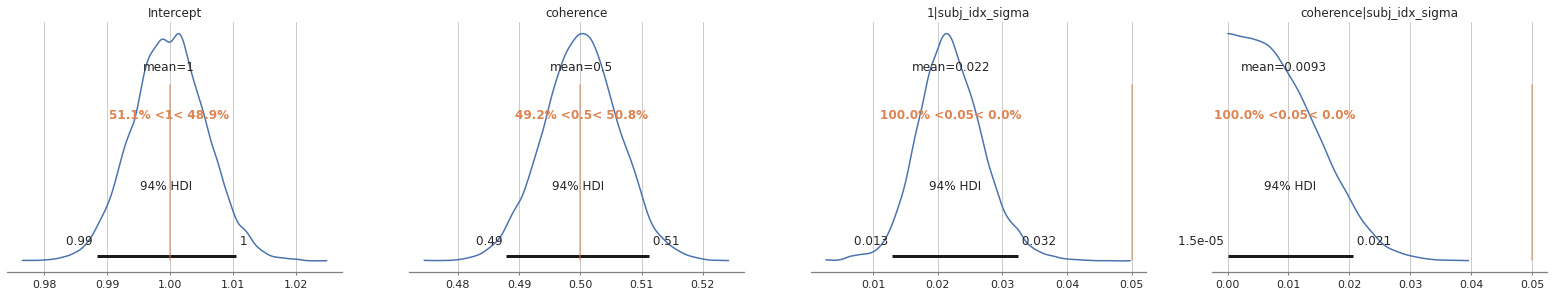

In [27]:
az.plot_posterior(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'], ref_val=[1,0.5,0.05,0.05]);


### model for t:

$t_{j}=\beta_{0,j} + \beta_{1,j}*C(attention)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [28]:
# contrust model
m2 = bmb.Model("t ~ 1 + attention + (1 + attention|subj_idx)", data=params)
# model fit
res2 = m2.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t_sigma, attention|subj_idx_offset, attention|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, attention, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 19 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
m2

Formula: t ~ 1 + attention + (1 + attention|subj_idx)
Family name: Gaussian
Link: identity
Observations: 240
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.2057, sigma: 0.3574)
    attention ~ Normal(mu: 0.0, sigma: 0.5055)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.3574))
    attention|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.5055))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.1011)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'attention'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>],
      dtype=object)

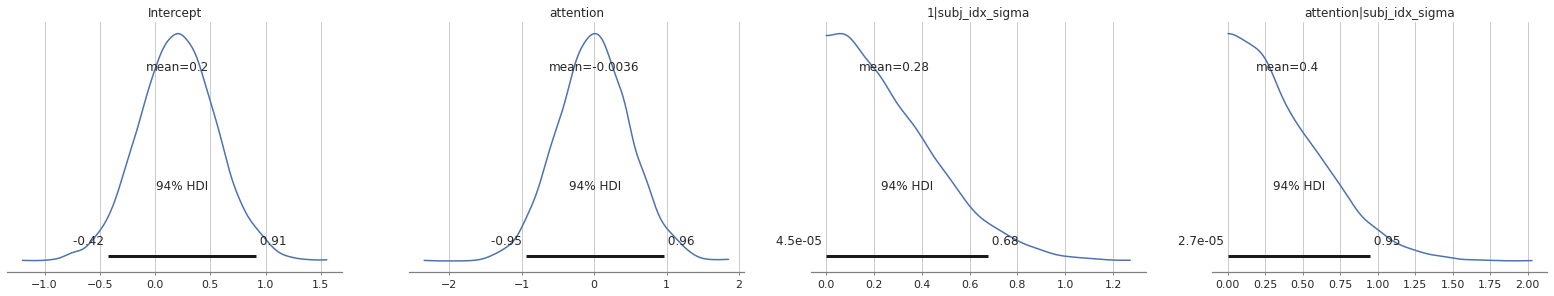

In [30]:
m2.plot_priors(var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'attention'}>,
        <AxesSubplot:title={'center':'attention'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'attention|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>]],
      dtype=object)

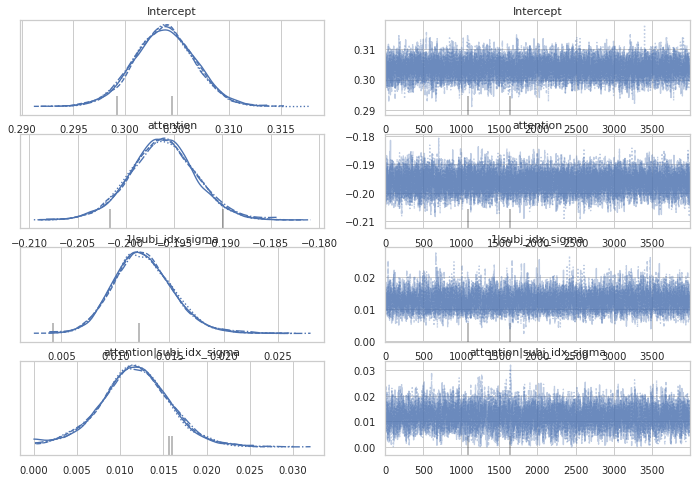

In [31]:
# Plot posteriors
az.plot_trace(
    res2,
    var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],
    compact=True,
)

In [32]:
az.summary(res2, var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.304,0.003,0.298,0.309,0.0,0.0,9148.0,10548.0,1.0
attention,-0.196,0.003,-0.203,-0.190,0.0,0.0,12704.0,8884.0,1.0
1|subj_idx_sigma,0.013,0.003,0.007,0.018,0.0,0.0,5136.0,6844.0,1.0
attention|subj_idx_sigma,0.012,0.004,0.004,0.020,0.0,0.0,3973.0,4497.0,1.0


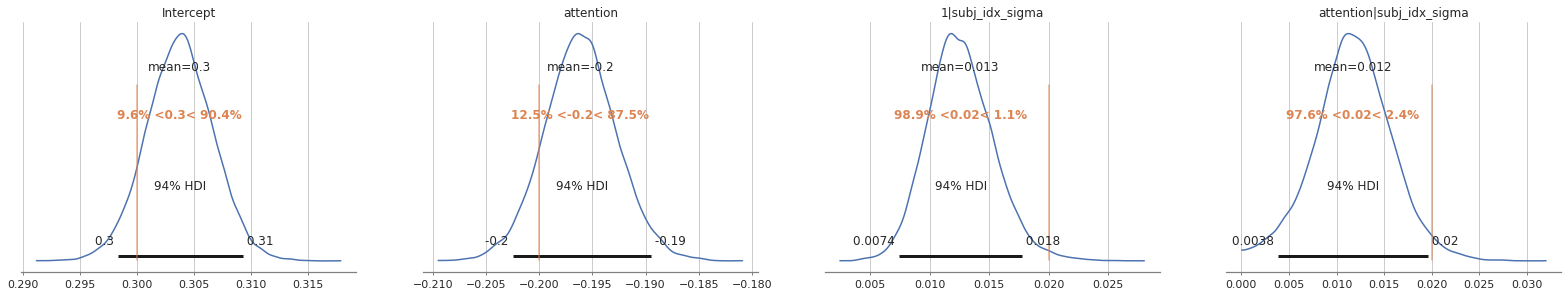

In [33]:
az.plot_posterior(res2,  var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'], ref_val=[0.3,-0.2,0.02,0.02]);


# simulation2(v ~ coherence, z ~ attention)

In [34]:
# set number of subjects and number of trials per level for the simulated experiment.
n_subjects = 30
trials_per_level = 100

# set the group parameter
# intercept and slope of v
v_int = 1
v_coh = 0.5
v_sig1 = 0.05
v_sig2 = 0.05
# intercept and slope of z
z_int = 0.5
z_pri = 0.2
z_sig1 = 0.02
z_sig2 = 0.02
# intercept of a
a_int = 1.4
a_sig = 0.1
# intercept of t
t_int = 0.2
t_sig = 0.05

## the hierarchical struction

In [35]:
# set the subject parameter
# v
v_int_subj = np.random.normal(v_int,v_sig1,[n_subjects,2])
v_coh_subj = np.random.normal(v_coh,v_sig2,[n_subjects,2])
# z
z_int_subj = np.random.normal(z_int,z_sig1,[n_subjects,2])
z_pri_subj = np.random.normal(z_pri,z_sig2,[n_subjects,2])
# a
a_int_subj = np.random.normal(a_int,a_sig,[n_subjects,2])
# t
t_int_subj = np.random.normal(t_int,t_sig,[n_subjects,2])

# dataframe
df = pd.DataFrame()
for i in range(n_subjects):
    
    # the different v of two experimental factor 
    v_high  = v_int_subj[i] + v_coh_subj[i]
    v_low = v_int_subj[i]
    # the different t of two experimental factor
    z_yes = z_int_subj[i] + z_pri_subj[i]
    z_no = z_int_subj[i]
    # the default parameter a
    a = a_int_subj[i]
    # the default parameter t
    t = t_int_subj[i]
    
    # set up parameters of DDM for four levels of the stimulus face(1).
    level1_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level2_a = {'v':v_high[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}
    level3_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_yes[0], 'sv':0, 'sz':0, 'st':0}
    level4_a = {'v':v_low[0], 'a':a[0], 't':t[0], 'z':z_no[0], 'sv':0, 'sz':0, 'st':0}

    # set up parameters of DDM for four levels of the stimulus car(0).
    level1_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_yes[1], 'sv':0, 'sz':0, 'st':0}
    level2_b = {'v':v_high[1], 'a':a[1], 't':t[1], 'z':z_no[1], 'sv':0, 'sz':0, 'st':0}
    level3_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_yes[1], 'sv':0, 'sz':0, 'st':0}
    level4_b = {'v':v_low[1], 'a':a[1], 't':t[1], 'z':z_no[1], 'sv':0, 'sz':0, 'st':0}

    # generate simulated data
    np.random.seed(123)
    data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                                 'level2':level2_a,
                                                 'level3':level3_a,
                                                 'level4':level4_a},
                                                 size = trials_per_level
                                                  )
    data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                                 'level2':level2_b,
                                                 'level3':level3_b,
                                                 'level4':level4_b},
                                                 size = trials_per_level
                                                 )
    # data
    # add column stimulus
    data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
    data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

    # combine the data from two stimulus
    data = data_a.append(data_b,ignore_index=True)
    
    # add subject
    data['subj_idx'] = pd.Series(np.ones((len(data)))*i, index=data.index).astype('int64')

    # add column coherence
    data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
    data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

    # add column spatial priotiziation
    data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
    data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0
    
    df = df.append(data)

    # params
    # create dataframe
    params_a = pd.DataFrame(params_a).T.reset_index().rename(columns={'index': 'condition'})
    params_b = pd.DataFrame(params_b).T.reset_index().rename(columns={'index': 'condition'})
    
    # add stmilulus
    params_a['stimulus'] = 1
    params_b['stimulus'] = 0

    # combine two stimulus
    param = params_a.append(params_b,ignore_index=True)
    
    # add column coherence
    param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
    param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0
    
    # add column spatial priotiziation
    param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
    param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0
    
    # add subject
    param['subj_idx'] = i

    # combine params
    params = params.append(param)

## the non-hierarchical struction

In [36]:
# set the random seed
np.random.seed(123)

# set up parameters of DDM for four levels of the stimulus face(1).
level1_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level2_a = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level4_a = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# set up parameters of DDM for four levels of the stimulus car(0).
level1_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level2_b = {'v':v_int+v_coh, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}
level3_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int+z_pri, 'sv':0, 'sz':0, 'st':0}
level4_b = {'v':v_int, 'a':a_int, 't':t_int, 'z':z_int, 'sv':0, 'sz':0, 'st':0}

# generate simulated data
np.random.seed(123)
data_a, params_a = hddm.generate.gen_rand_data({'level1':level1_a,
                                             'level2':level2_a,
                                             'level3':level3_a,
                                             'level4':level4_a},
                                             size = trials_per_level,
                                             subjs = n_subjects)
data_b, params_b = hddm.generate.gen_rand_data({'level1':level1_b,
                                             'level2':level2_b,
                                             'level3':level3_b,
                                             'level4':level4_b},
                                             size = trials_per_level,
                                             subjs = n_subjects
)
# add column stimulus
data_a['stimulus'] = pd.Series(np.ones((len(data_a))), index=data_a.index)   # face
data_b['stimulus'] = pd.Series(np.ones((len(data_b)))*0, index=data_a.index) # car

# combine the data from two stimulus
data = data_a.append(data_b,ignore_index=True)

# add column coherence
data.loc[(data['condition']=='level1')|(data['condition']=='level2'),'coherence'] = 1    
data.loc[(data['condition']=='level3')|(data['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
data.loc[(data['condition']=='level1')|(data['condition']=='level3'),'attention'] = 1    
data.loc[(data['condition']=='level2')|(data['condition']=='level4'),'attention'] = 0

# params
# create dataframe
levels = ['level1','level2','level3','level4']

paramsa = pd.DataFrame()
paramsb = pd.DataFrame()

# combine the params for each level
for level in levels:
    parama = pd.DataFrame(params_a[level]).reset_index().rename(columns={'index': 'subj_idx'})
    parama['condition'] = level
    paramsa = paramsa.append(parama,ignore_index=True)
    
    paramb = pd.DataFrame(params_b[level]).reset_index().rename(columns={'index': 'subj_idx'})
    paramb['condition'] = level
    paramsb = paramsb.append(paramb,ignore_index=True)

# add stmilulus
paramsa['stimulus'] = 1
paramsb['stimulus'] = 0
# combine two stimulus
param = paramsa.append(paramsb,ignore_index=True)

# add column coherence
param.loc[(param['condition']=='level1')|(param['condition']=='level2'),'coherence'] = 1
param.loc[(param['condition']=='level3')|(param['condition']=='level4'),'coherence'] = 0

# add column spatial priotiziation
param.loc[(param['condition']=='level1')|(param['condition']=='level3'),'attention'] = 1
param.loc[(param['condition']=='level2')|(param['condition']=='level4'),'attention'] = 0

## the visualization 

In [37]:
df

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.510800,1.0,0,level1,1.0,1.0,1.0
1,0.355800,1.0,0,level1,1.0,1.0,1.0
2,0.342800,1.0,0,level1,1.0,1.0,1.0
3,0.433800,1.0,0,level1,1.0,1.0,1.0
4,0.527800,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
795,0.404094,0.0,29,level4,0.0,0.0,0.0
796,0.368094,1.0,29,level4,0.0,0.0,0.0
797,0.252094,1.0,29,level4,0.0,0.0,0.0
798,0.276094,1.0,29,level4,0.0,0.0,0.0


In [38]:
data

,rt,response,subj_idx,condition,stimulus,coherence,attention
0,0.345013,1.0,0,level1,1.0,1.0,1.0
1,0.333509,1.0,0,level1,1.0,1.0,1.0
2,0.435129,1.0,0,level1,1.0,1.0,1.0
3,0.582129,1.0,0,level1,1.0,1.0,1.0
4,0.644750,1.0,0,level1,1.0,1.0,1.0
...,...,...,...,...,...,...,...
23995,0.626126,1.0,29,level4,0.0,0.0,0.0
23996,0.510086,1.0,29,level4,0.0,0.0,0.0
23997,1.332681,1.0,29,level4,0.0,0.0,0.0
23998,0.364289,1.0,29,level4,0.0,0.0,0.0


In [39]:
params

,condition,v,a,t,z,sv,sz,st,stimulus,coherence,attention,subj_idx
0,level1,1.561993,1.367778,0.170181,0.457978,0.0,0.0,0.0,1,1.0,1.0,0
1,level2,1.561993,1.367778,0.316372,0.457978,0.0,0.0,0.0,1,1.0,0.0,0
2,level3,1.013021,1.367778,0.170181,0.457978,0.0,0.0,0.0,1,0.0,1.0,0
3,level4,1.013021,1.367778,0.316372,0.457978,0.0,0.0,0.0,1,0.0,0.0,0
4,level1,1.355954,1.345162,0.144846,0.571113,0.0,0.0,0.0,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3,level4,0.963496,1.422642,0.360326,0.490989,0.0,0.0,0.0,1,0.0,0.0,29
4,level1,1.540779,1.355393,0.104094,0.716501,0.0,0.0,0.0,0,1.0,1.0,29
5,level2,1.540779,1.355393,0.104094,0.501336,0.0,0.0,0.0,0,1.0,0.0,29
6,level3,1.033166,1.355393,0.104094,0.716501,0.0,0.0,0.0,0,0.0,1.0,29


In [40]:
param

,subj_idx,v,a,t,z,sv,sz,st,condition,stimulus,coherence,attention
0,0,1.391437,1.499735,0.228298,0.549371,0.165144,0.126594,0.149139,level1,1,1.0,1.0
1,1,1.436110,1.328251,0.102744,0.656033,0.108822,0.088777,0.021459,level1,1,1.0,1.0
2,2,1.459784,1.415632,0.160677,0.725108,0.154792,0.117540,0.017293,level1,1,1.0,1.0
3,3,1.340556,1.316089,0.219245,0.781033,0.116799,0.049573,0.040863,level1,1,1.0,1.0
4,4,1.401180,1.474330,0.128884,0.757748,0.094922,0.088477,0.083453,level1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235,25,0.980489,1.480073,0.236111,0.549541,0.007183,0.156149,0.003886,level4,0,0.0,0.0
236,26,0.931164,1.560618,0.065971,0.600477,0.051703,0.016966,0.059456,level4,0,0.0,0.0
237,27,0.939921,1.454564,0.322443,0.522298,0.049039,0.049716,0.172372,level4,0,0.0,0.0
238,28,0.984148,1.511818,0.083433,0.299815,0.092479,0.160644,0.136113,level4,0,0.0,0.0


### the description subj level

In [41]:
df.rt.describe()

count    24000.000000
mean         0.539592
std          0.311979
min          0.104838
25%          0.326521
50%          0.447519
75%          0.654609
max          2.435206
Name: rt, dtype: float64

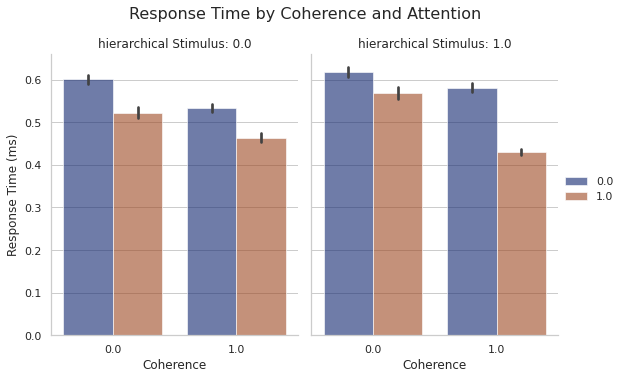

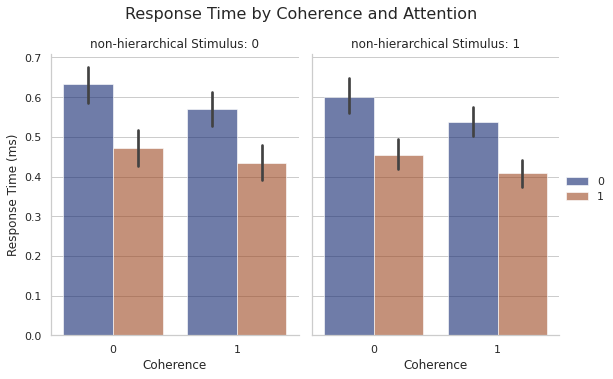

In [42]:
# hierarchical
# get the mean of accurate RTs
df_rt_sum = df[df['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
df_rt_sum['stimulus'] = df_rt_sum['stimulus'].astype('int64')
df_rt_sum['coherence'] = df_rt_sum['coherence'].astype('int64')
df_rt_sum['attention'] = df_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = df,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

# non-hierarchical
# get the mean of accurate RTs
data_rt_sum = data[data['response']==1].groupby(['subj_idx','coherence','attention','stimulus'])['rt'].mean().reset_index()
# change the type of columns
data_rt_sum['stimulus'] = data_rt_sum['stimulus'].astype('int64')
data_rt_sum['coherence'] = data_rt_sum['coherence'].astype('int64')
data_rt_sum['attention'] = data_rt_sum['attention'].astype('int64')

# set the canvas 
g = sns.FacetGrid(data = data_rt_sum,
                  col = 'stimulus',
                  height = 5,
                  aspect = 0.8,
                  sharex = True,
                  sharey = True)
# map the dataframe to the canvas
g.map_dataframe(sns.barplot,
                x = 'coherence',
                y = 'rt',
                hue = 'attention',
                palette = 'dark',
                alpha = 0.6)
# add labels to the figure
g.set_xlabels("Coherence")
g.set_ylabels("Response Time (ms)")
g.set_titles("non-hierarchical Stimulus: {col_name}")
g.fig.suptitle("Response Time by Coherence and Attention", 
               y=1.05, 
               fontsize=16)
g.add_legend()

Text(0.5, 1, 'Response Time by Coherence and Attention')

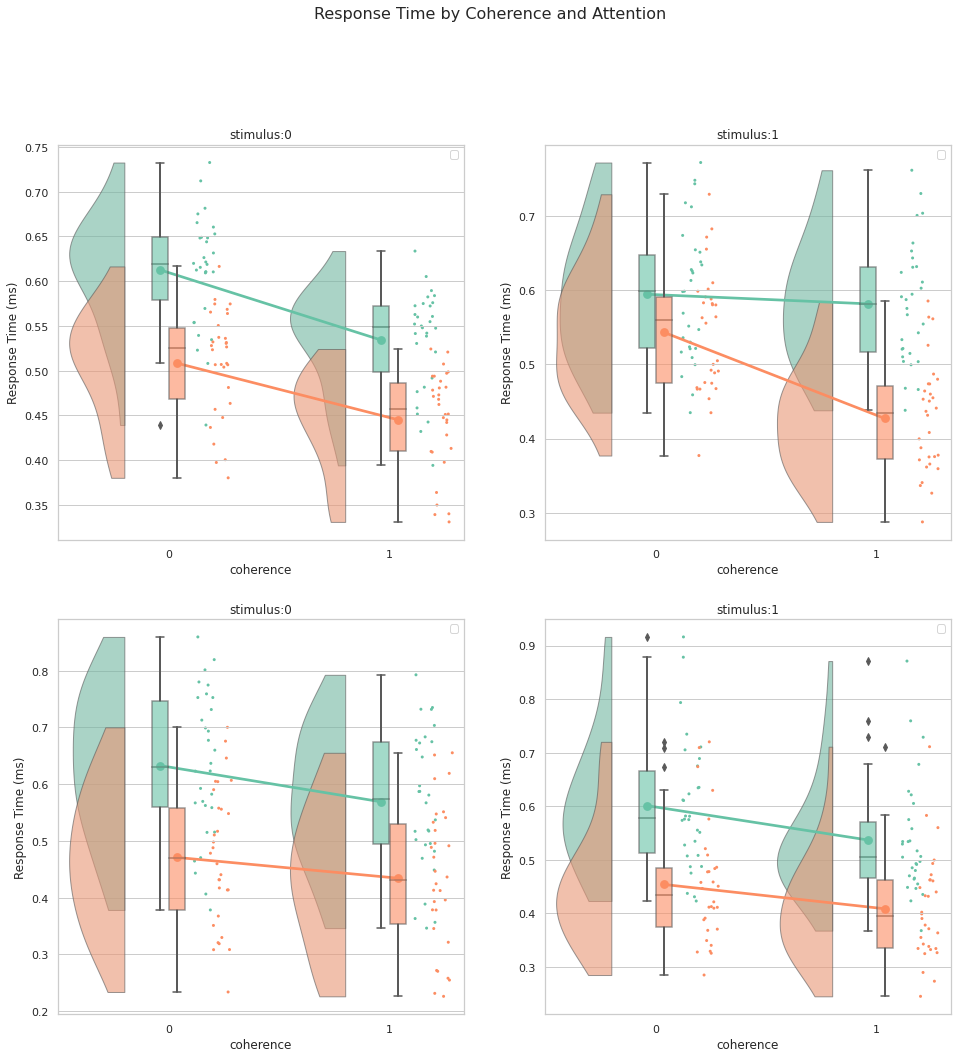

In [43]:
f, ax = plt.subplots(2,2,figsize=(16, 16))
# non-hierarchical
# the right figure
ax[0,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,0].legend('')
ax[0,0].set_title('stimulus:0')
ax[0,0].set_ylabel('Response Time (ms)')
# the right figure
ax[0,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = df_rt_sum[df_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[0,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[0,1].legend('')
ax[0,1].set_title('stimulus:1')
ax[0,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)
# non-hierarchical
ax[1,0] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==0], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,0], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,0].legend('')
ax[1,0].set_title('stimulus:0')
ax[1,0].set_ylabel('Response Time (ms)')
# the right figure
ax[1,1] = pt.RainCloud(x = 'coherence', 
                  y = 'rt', 
                  hue = 'attention', 
                  data = data_rt_sum[data_rt_sum['stimulus']==1], 
                  palette = 'Set2', 
                  bw = 0.6, 
                  width_viol=.5,
                  ax = ax[1,1], 
                  orient = 'v', 
                  alpha = .6, 
                  dodge = True, 
                  pointplot = True, 
                  move = 0.2)
ax[1,1].legend('')
ax[1,1].set_title('stimulus:1')
ax[1,1].set_ylabel('Response Time (ms)')
plt.suptitle("Response Time by Coherence and Attention", 
               y=1, 
               fontsize=16)

In [44]:
# ANOVA for hierarchical
model_aovrm3way = AnovaRM(df,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(df,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                    1782.9772 1.0000 29.0000 0.0000
attention                    1099.5249 1.0000 29.0000 0.0000
stimulus                        1.0975 1.0000 29.0000 0.3035
coherence:attention          2576.2633 1.0000 29.0000 0.0000
coherence:stimulus             37.7970 1.0000 29.0000 0.0000
attention:stimulus             17.8587 1.0000 29.0000 0.0002
coherence:attention:stimulus 3891.1078 1.0000 29.0000 0.0000

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
coherence                    1100.2279 1.0000 29.0000 0.0000
attention                     782.3936 1.0000 29.0000 0.0000
stimulus                        0.4805 1.0000 29.0000 0.4937
coherence:attention             3.6343 1.0000 29.0000 0.0666
coherence:stimulus

In [45]:
# ANOVA for non-hierarchical
model_aovrm3way = AnovaRM(data,
                   'rt',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)
# ANOVA for response
model_aovrm3way = AnovaRM(data,
                   'response',
                   'subj_idx',
                   within=['coherence','attention','stimulus'],
                   aggregate_func='mean')
res3way=model_aovrm3way.fit()
print(res3way)

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    125.9041 1.0000 29.0000 0.0000
attention                    386.1473 1.0000 29.0000 0.0000
stimulus                       0.8634 1.0000 29.0000 0.3604
coherence:attention            2.0507 1.0000 29.0000 0.1628
coherence:stimulus             2.0094 1.0000 29.0000 0.1670
attention:stimulus             1.0032 1.0000 29.0000 0.3248
coherence:attention:stimulus   0.3304 1.0000 29.0000 0.5699

                           Anova
                             F Value  Num DF  Den DF Pr > F
-----------------------------------------------------------
coherence                    158.0877 1.0000 29.0000 0.0000
attention                    413.7826 1.0000 29.0000 0.0000
stimulus                       0.2006 1.0000 29.0000 0.6576
coherence:attention           14.6912 1.0000 29.0000 0.0006
coherence:stimulus            -0.

### rt distribution

In [46]:
# flip the rt of response 0 to negative
df.loc[df['response']==0,'rt'] = -df.loc[df['response']==0,'rt']

In [47]:
# flip the rt of response 0 to negative
data.loc[data['response']==0,'rt'] = -data.loc[data['response']==0,'rt']

Text(0, 0.5, 'counts')

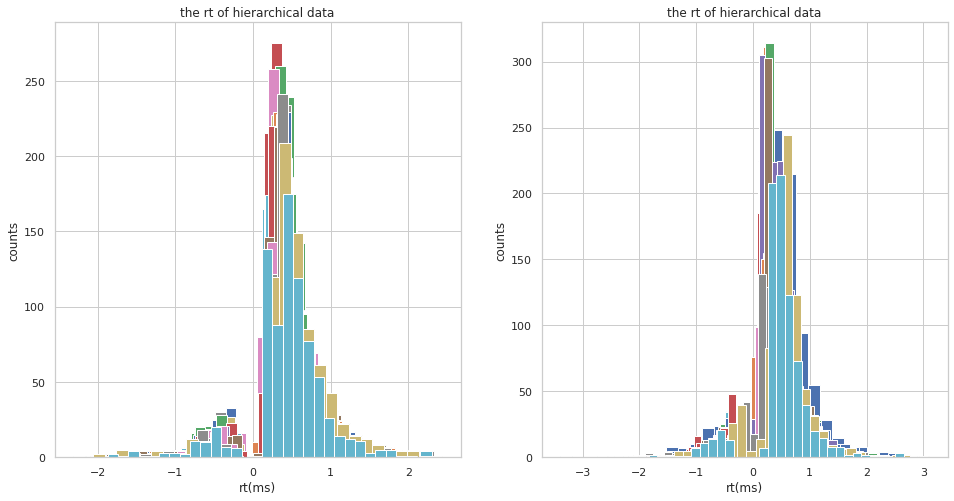

In [48]:
# create the figure 
f, ax = plt.subplots(1,2,figsize=(16, 8))

# the rt of hierarchical data
df.groupby(['subj_idx']).rt.hist(bins=30,ax=ax[0])
# the labels of hierarchical data
ax[0].set_title('the rt of hierarchical data')
ax[0].set_xlabel('rt(ms)')
ax[0].set_ylabel('counts')

# the rt of non-hierarchical data
data.groupby(['subj_idx']).rt.hist(bins=30,ax=ax[1])
# the labels of hierarchical data
ax[1].set_title('the rt of hierarchical data')
ax[1].set_xlabel('rt(ms)')
ax[1].set_ylabel('counts')

### rt distribution of different conditions

Text(0, 0.5, 'counts')

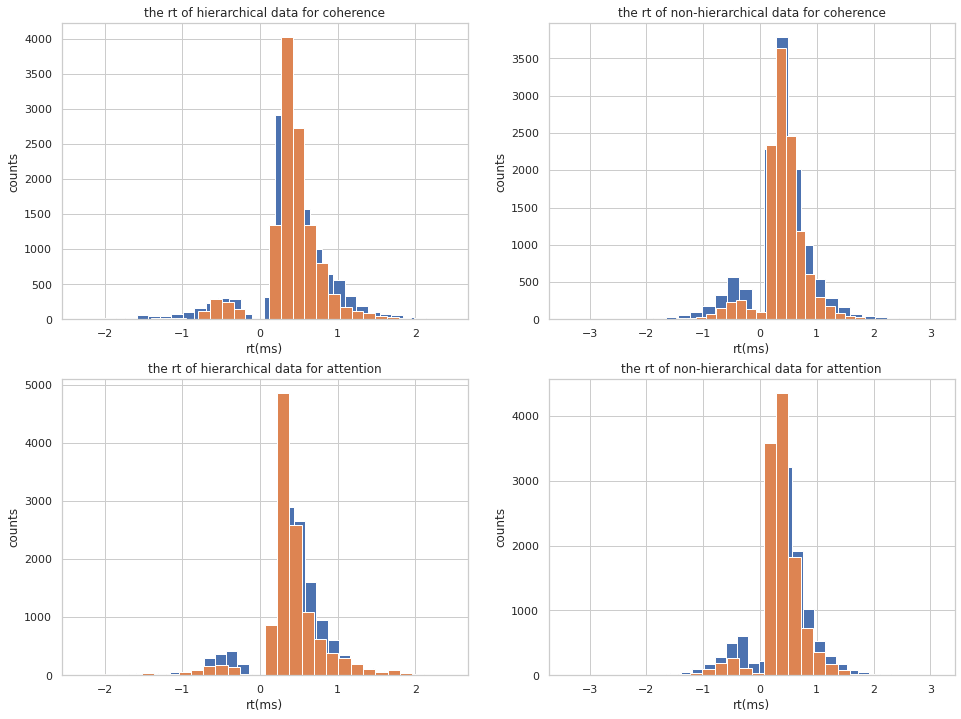

In [49]:
# create the figure 
f, ax = plt.subplots(2,2,figsize=(16, 12))

# the rt of hierarchical data for coherence
df.groupby(['coherence']).rt.hist(bins=30,ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('the rt of hierarchical data for coherence')
ax[0,0].set_xlabel('rt(ms)')
ax[0,0].set_ylabel('counts')

# the rt of non-hierarchical data for coherence
data.groupby(['coherence']).rt.hist(bins=30,ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('the rt of non-hierarchical data for coherence')
ax[0,1].set_xlabel('rt(ms)')
ax[0,1].set_ylabel('counts')

# the rt of hierarchical data for attention
df.groupby(['attention']).rt.hist(bins=30,ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('the rt of hierarchical data for attention')
ax[1,0].set_xlabel('rt(ms)')
ax[1,0].set_ylabel('counts')

# the rt of non-hierarchical data for attention
data.groupby(['attention']).rt.hist(bins=30,ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('the rt of non-hierarchical data for attention')
ax[1,1].set_xlabel('rt(ms)')
ax[1,1].set_ylabel('counts')

### the parameter distributions

Text(0, 0.5, 'density')

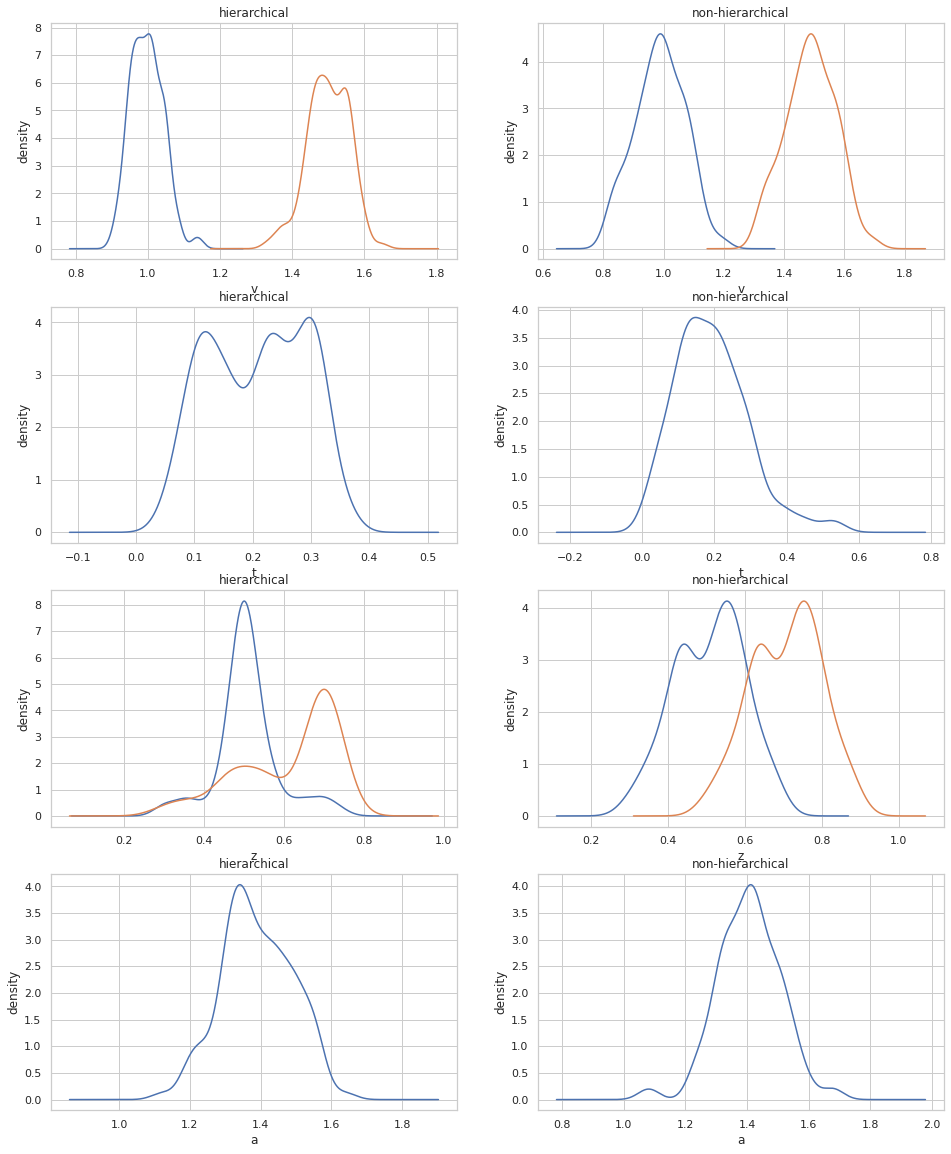

In [50]:
# create the figure 
f, ax = plt.subplots(4,2,figsize=(16, 20))

# the rt of hierarchical data for coherence
# v
params.groupby(['coherence']).v.plot.kde(ax=ax[0,0])
# the labels of hierarchical data
ax[0,0].set_title('hierarchical')
ax[0,0].set_xlabel('v')
ax[0,0].set_ylabel('density')

# t
params.t.plot.kde(ax=ax[1,0])
# the labels of hierarchical data
ax[1,0].set_title('hierarchical')
ax[1,0].set_xlabel('t')
ax[1,0].set_ylabel('density')

# z
params.groupby(['attention']).z.plot.kde(ax=ax[2,0])
# the labels of hierarchical data
ax[2,0].set_title('hierarchical')
ax[2,0].set_xlabel('z')
ax[2,0].set_ylabel('density')

# a
params.a.plot.kde(ax=ax[3,0])
# the labels of hierarchical data
ax[3,0].set_title('hierarchical')
ax[3,0].set_xlabel('a')
ax[3,0].set_ylabel('density')

# the rt of non-hierarchical data for coherence
# v
param.groupby(['coherence']).v.plot.kde(ax=ax[0,1])
# the labels of hierarchical data
ax[0,1].set_title('non-hierarchical')
ax[0,1].set_xlabel('v')
ax[0,1].set_ylabel('density')

# t
param.t.plot.kde(ax=ax[1,1])
# the labels of hierarchical data
ax[1,1].set_title('non-hierarchical')
ax[1,1].set_xlabel('t')
ax[1,1].set_ylabel('density')

# z
param.groupby(['attention']).z.plot.kde(ax=ax[2,1])
# the labels of hierarchical data
ax[2,1].set_title('non-hierarchical')
ax[2,1].set_xlabel('z')
ax[2,1].set_ylabel('density')

# a
param.a.plot.kde(ax=ax[3,1])
# the labels of hierarchical data
ax[3,1].set_title('non-hierarchical')
ax[3,1].set_xlabel('a')
ax[3,1].set_ylabel('density')

## linear regression

In previous part, when we set the population parameter of different condition, the stochastic subject parameter would be generated.

In this part, we want to check whether the we can contruct the linear regresiion and recover the grand param.



### model for v:

$v_{j}=\beta_{0,j} + \beta_{1,j}*C(coherence)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [51]:
# contrust model
m1 = bmb.Model("v ~ 1 + coherence + (1 + coherence|subj_idx)", data=params)
# model fit
res1 = m1.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_sigma, coherence|subj_idx_offset, coherence|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, coherence, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 20 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [52]:
m1

Formula: v ~ 1 + coherence + (1 + coherence|subj_idx)
Family name: Gaussian
Link: identity
Observations: 480
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 1.2485, sigma: 0.9058)
    coherence ~ Normal(mu: 0.0, sigma: 1.2811)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.9058))
    coherence|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 1.2811))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.2562)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'coherence'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>],
      dtype=object)

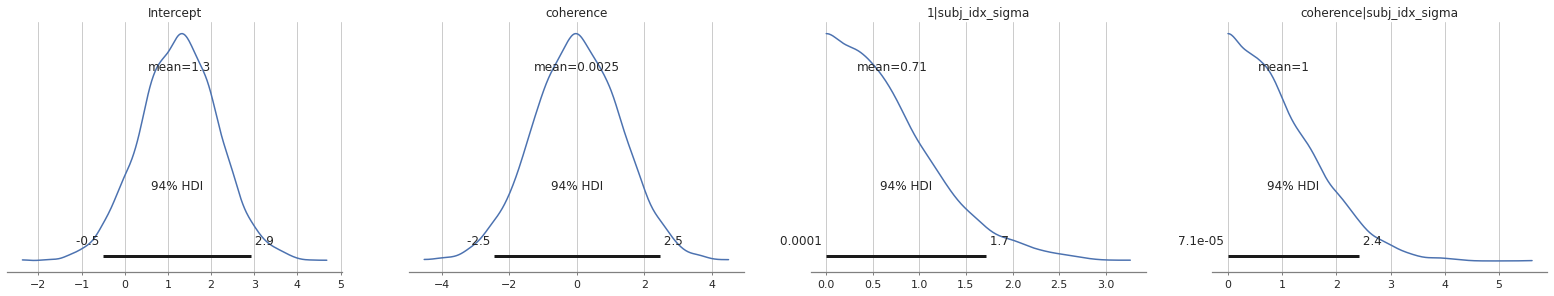

In [53]:
m1.plot_priors(var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'coherence'}>,
        <AxesSubplot:title={'center':'coherence'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'coherence|subj_idx_sigma'}>]],
      dtype=object)

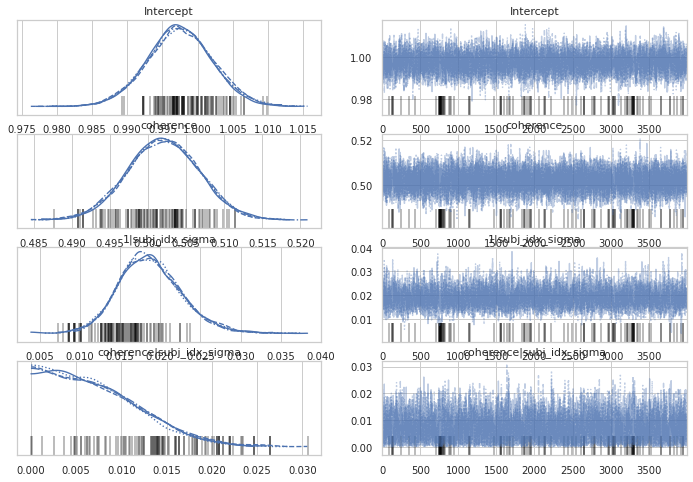

In [54]:
# Plot posteriors
az.plot_trace(
    res1,
    var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'],
    compact=True,
)

In [55]:
az.summary(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma','v_sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.997,0.005,0.989,1.006,0.0,0.0,5632.0,7027.0,1.0
coherence,0.502,0.005,0.493,0.510,0.0,0.0,9285.0,7091.0,1.0
1|subj_idx_sigma,0.019,0.004,0.012,0.027,0.0,0.0,3329.0,2965.0,1.0
coherence|subj_idx_sigma,0.007,0.005,0.000,0.016,0.0,0.0,3036.0,3784.0,1.0
v_sigma,0.048,0.002,0.045,0.051,0.0,0.0,10739.0,5610.0,1.0


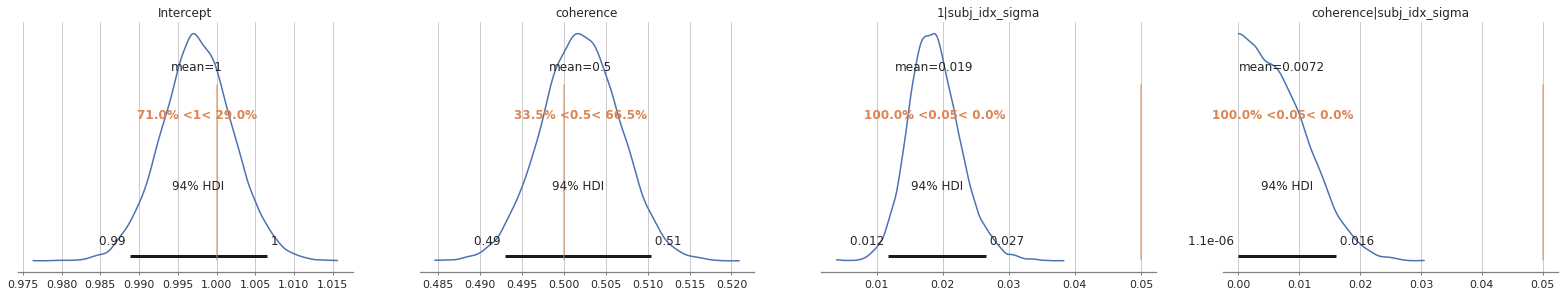

In [56]:
az.plot_posterior(res1, var_names=['Intercept','coherence','1|subj_idx_sigma','coherence|subj_idx_sigma'], ref_val=[v_int,v_coh,v_sig1,v_sig2]);


### model for z:

$z_{j}=\beta_{0,j} + \beta_{1,j}*C(attention)$

$\beta_{0,j} \sim N(\beta_{0},\beta_{sig1}) $

$\beta_{1,j} \sim N(\beta_{1},\beta_{sig2})$


In [57]:
# contrust model
m2 = bmb.Model("z ~ 1 + attention + (1 + attention|subj_idx)", data=params)
# model fit
res2 = m2.fit(draws=4000, tune=1000, chains=4,cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_sigma, attention|subj_idx_offset, attention|subj_idx_sigma, 1|subj_idx_offset, 1|subj_idx_sigma, attention, Intercept]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 15 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [58]:
m2

Formula: z ~ 1 + attention + (1 + attention|subj_idx)
Family name: Gaussian
Link: identity
Observations: 480
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.5588, sigma: 0.4038)
    attention ~ Normal(mu: 0.0, sigma: 0.5711)

  Group-level effects
    1|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.4038))
    attention|subj_idx ~ Normal(mu: 0, sigma: HalfNormal(sigma: 0.5711))

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.1142)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### priors

array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'attention'}>,
       <AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
       <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>],
      dtype=object)

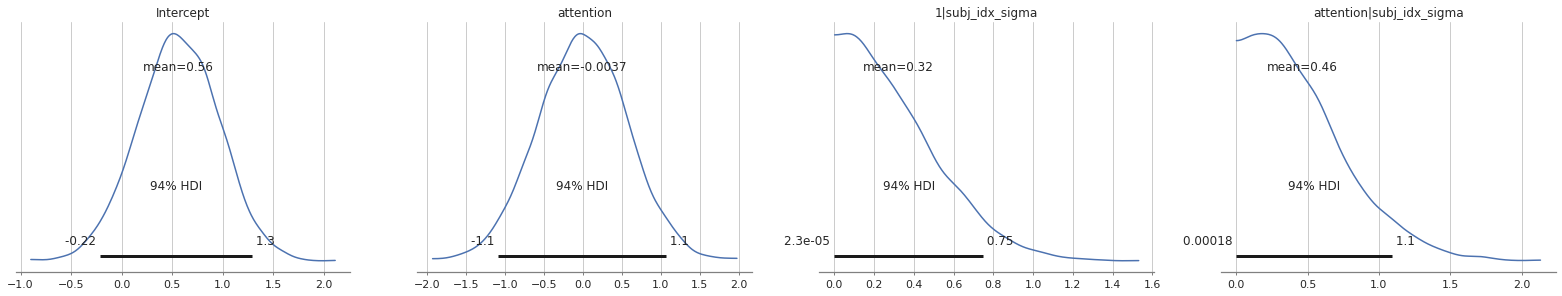

In [59]:
m2.plot_priors(var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'])

### posteriors

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'attention'}>,
        <AxesSubplot:title={'center':'attention'}>],
       [<AxesSubplot:title={'center':'1|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'1|subj_idx_sigma'}>],
       [<AxesSubplot:title={'center':'attention|subj_idx_sigma'}>,
        <AxesSubplot:title={'center':'attention|subj_idx_sigma'}>]],
      dtype=object)

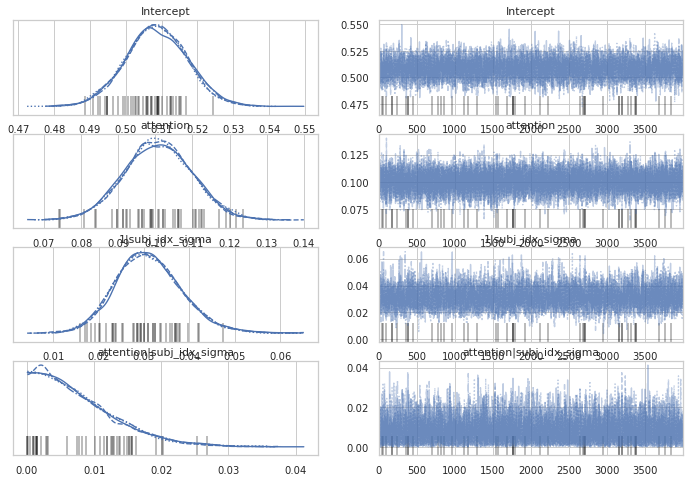

In [60]:
# Plot posteriors
az.plot_trace(
    res2,
    var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'],
    compact=True,
)

In [61]:
az.summary(res2, var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma','z_sigma'],)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.509,0.009,0.492,0.524,0.0,0.0,6514.0,8835.0,1.0
attention,0.101,0.009,0.083,0.118,0.0,0.0,14165.0,10152.0,1.0
1|subj_idx_sigma,0.031,0.007,0.017,0.045,0.0,0.0,4891.0,6720.0,1.0
attention|subj_idx_sigma,0.008,0.006,0.000,0.019,0.0,0.0,7150.0,6639.0,1.0
z_sigma,0.099,0.003,0.092,0.105,0.0,0.0,12678.0,10580.0,1.0


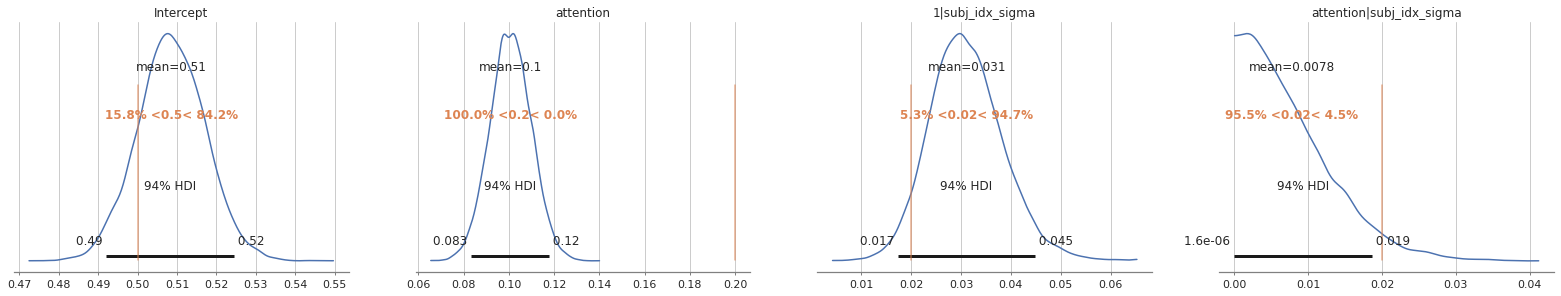

In [62]:
az.plot_posterior(res2,  var_names=['Intercept','attention','1|subj_idx_sigma','attention|subj_idx_sigma'], ref_val=[z_int,z_pri,z_sig1,z_sig2]);
